In [1]:
import pandas as pd
import numpy as np
import requests
import os
import io
import datetime
import matplotlib.pyplot as plt

API_KEY = os.environ["ALPHA_VANTAGE_API_KEY"]

plt.rcParams["figure.figsize"] = 20, 8

In [2]:
def req_to_csv(url):
    r = requests.get(url).content
    return pd.read_csv(io.StringIO(r.decode('utf-8')))

def yyyymmdd_to_yyyymm(d):
    return d[0:7]

## Stocks

In [3]:
vti = req_to_csv(f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol=VTI&datatype=csv&apikey={API_KEY}")
vti['yyyymm'] = vti.timestamp.apply(yyyymmdd_to_yyyymm)
vti.head()

,timestamp,open,high,low,close,adjusted close,volume,dividend amount,yyyymm
0,2022-05-09,207.15,215.910,197.86,198.65,198.6500,38284947,0.0000,2022-05
1,2022-04-29,228.66,230.880,206.71,206.88,206.8800,83252984,0.0000,2022-04
2,2022-03-31,220.62,233.360,209.27,227.67,227.6700,107876354,0.7082,2022-03
3,2022-02-28,227.94,231.810,207.00,221.17,220.4727,95578706,0.0000,2022-02
4,2022-01-31,242.42,244.058,212.10,226.81,226.0950,119514425,0.0000,2022-01


## Bitcoin

In [4]:
btc = req_to_csv(f"https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_MONTHLY&symbol=BTC&market=CNY&&datatype=csv&apikey={API_KEY}")
btc['yyyymm'] = btc.timestamp.apply(yyyymmdd_to_yyyymm)
btc.head()

,timestamp,open (CNY),high (CNY),low (CNY),close (CNY),open (USD),high (USD),low (USD),close (USD),volume,market cap (USD),yyyymm
0,2022-05-10,253236.468600,269339.960215,200070.726800,201811.715745,37630.80,40023.77,29730.40,29989.11,6.609459e+05,6.609459e+05,2022-05
1,2022-04-30,306261.900325,319275.138245,252882.496900,253236.468600,45510.35,47444.11,37578.20,37630.80,1.267656e+06,1.267656e+06,2022-04
2,2022-03-31,290445.220000,324293.528280,250034.572500,306261.833030,43160.00,48189.84,37155.00,45510.34,1.501279e+06,1.501279e+06,2022-03
3,2022-02-28,258863.003550,308352.419500,230971.783260,290445.220000,38466.90,45821.00,34322.28,43160.00,1.253514e+06,1.253514e+06,2022-02
4,2022-01-31,311016.830435,322948.705000,221516.095515,258863.003550,46216.93,47990.00,32917.17,38466.90,1.279407e+06,1.279407e+06,2022-01


## Merge & Transform

In [5]:
dt = vti[['yyyymm', 'adjusted close']].merge(btc[['yyyymm', 'close (USD)']], on='yyyymm', how='inner')
dt.rename(columns={'adjusted close': 'VTI', 'close (USD)': 'BTC'}, inplace=True)
print(dt.shape)
dt.head()

(33, 3)


,yyyymm,VTI,BTC
0,2022-05,198.6500,29989.11
1,2022-04,206.8800,37630.80
2,2022-03,227.6700,45510.34
3,2022-02,220.4727,43160.00
4,2022-01,226.0950,38466.90


In [6]:
dt['VTI_D'] = dt.VTI / dt.VTI.shift() - 1
dt['BTC_D'] = dt.BTC / dt.BTC.shift() - 1
dt = dt.iloc[1:dt.shape[0]].copy()
dt.sort_values(by='yyyymm', inplace=True)

In [7]:
dt.head()

,yyyymm,VTI,BTC,VTI_D,BTC_D
32,2019-09,145.2511,8289.34,-0.020625,-0.093154
31,2019-10,148.3100,9140.85,-0.036496,0.212011
30,2019-11,153.9277,7541.89,-0.027275,0.048179
29,2019-12,158.2438,7195.23,0.000611,-0.230694
28,2020-01,158.1471,9352.89,0.086945,0.097292


## Visualize

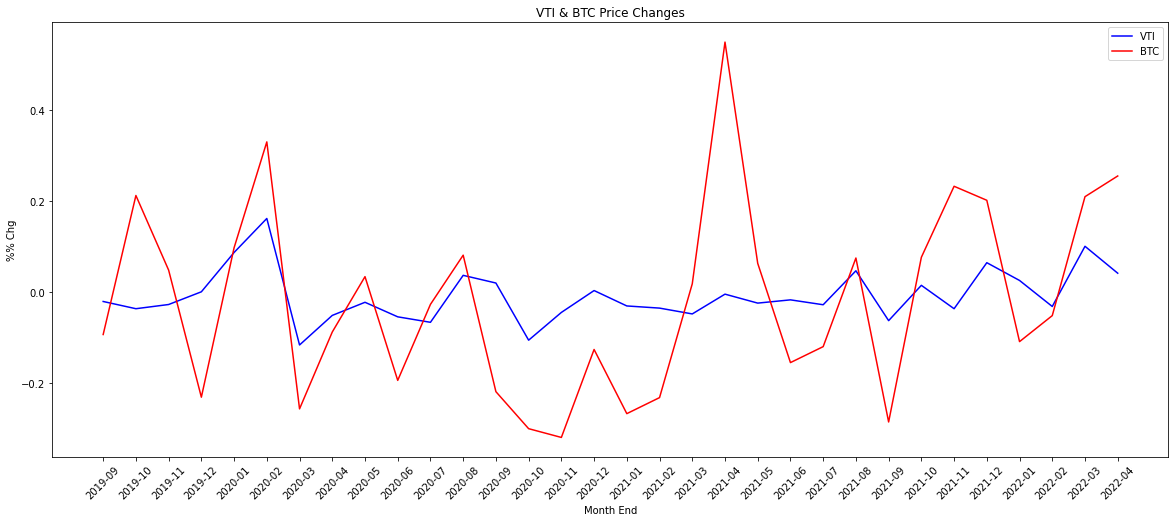

In [8]:
plt.plot(dt.yyyymm, dt.VTI_D, color='blue', label='VTI')
plt.plot(dt.yyyymm, dt.BTC_D, color='red', label='BTC')
plt.xticks(rotation=45)
plt.xlabel('Month End')
plt.ylabel('%% Chg')
plt.title('VTI & BTC Price Changes')
plt.legend()
plt.show()

## Correlation

In [9]:
dt[['VTI_D', 'BTC_D']].corr()

,VTI_D,BTC_D
VTI_D,1.000000,0.567074
BTC_D,0.567074,1.000000
